In [1]:
# imports
import ROOT
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('/exp/icarus/app/users/lkashur/medulla/medulla/spineplot/styles/pi0ana.mplstyle')
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
#from concurrent.futures import ThreadPoolExecutor
import gc

In [2]:
# helper functions
def add_plot_labels(ax, pot, vadj=0.025, title=str()):
    xrange = ax.get_xlim() 
    yrange = ax.get_ylim()                                                                                                                     

    usex = xrange[0]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    s = r'$\bf{ICARUS}$ Simulation Preliminary'
    ax.text(x=usex, y=usey, s=s, fontsize=13, color='#d67a11')   
    
    usex = xrange[1]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    mag = int(np.floor(np.log10(pot)))
    usepot = pot/10**mag
    s = f'{usepot:.2f}'+f'$\\times 10^{{{mag}}}$ POT'
    ax.text(x=usex, y=usey, s=s, fontsize=13, color='black', horizontalalignment='right')

def calculate_efficiency(sig_df, cuts_string):

    # Denominator                                                                                                                                                                                          
    total_signal_events = len(sig_df)

    # Numerator
    selected_signal_events = len(sig_df.query(cuts_string))

    eff =  selected_signal_events / total_signal_events
    return eff

def calculate_efficiency_by_cut(sig_df, cuts):

    # No cut                                                                                                                                                                                       
    print(f'No Cut Efficiency: 100.0')

    successive_cuts = []
    for i in range(1, len(cuts) + 1):
        successive_cuts.append(cuts[:i])

    for sc in successive_cuts:
        cond_string = str()
        for i,c in enumerate(sc):
            cond_string += c
            if i != len(sc) - 1: cond_string += ' & '

        sel_by_cut = sig_df.query(cond_string)
        eff = 100 * len(sel_by_cut) / len(sig_df)
        print(f'{cond_string} Efficiency: {eff:.1f}')

def plot_eff_by_var(sig_df, pot_sim, var, cuts, ana_eff_bins_equal=True, nbins_eff=25):
    bcs = []
    bxerr0s = []
    bxerr1s = []
    byerr0s = []
    byerr1s = []
    vals = []

    # Filtering (keep in range of analyis bins)                                                                                                                                
    sig_df = sig_df[(sig_df[var] > bin_edges[0]) & (sig_df[var] < bin_edges[-1])]

    # Apply analyis binning                                                                                                                                                    
    ana_bins_df = pd.DataFrame(bin_edges, columns=['bin'])

    sig_df['var_q_ana'] = pd.cut(sig_df[var], ana_bins_df['bin'])

    # Apply eff binning                                                                                                                                                        
    _nbins_eff = 0
    if ana_eff_bins_equal:
        _nbins_eff = len(bin_edges) - 1
        sig_df['var_q_eff'] = pd.cut(sig_df[var], bin_edges)
    else:
        _nbins_eff = nbins_eff
        sig_df['var_q_eff'] = pd.cut(sig_df[var], np.linspace(bin_edges[0], bin_edges[-1], _nbins_eff+1))

    #######                                                                                                                                                                    
    ### ana                                                                                                                                                                    
    #######                                                                                                                                                                    
    hedges_ana = sorted([i.left for i in sig_df.var_q_ana.unique().tolist()])
    lastedge_ana = max([i.right for i in sig_df.var_q_ana.unique().tolist()])
    hedges_ana.append(lastedge_ana)
    hedges_ana = np.array(hedges_ana)
    counts = []
    for i,(name,group) in enumerate(sig_df.groupby('var_q_ana')):
        counts.append(len(group))

    ##########                                                                                                                                                                 
    ### eff                                                                                                                                                                    
    ##########                                                                                                                                                                 
    hedges_eff = sorted([i.left for i in sig_df.var_q_eff.unique().tolist()])
    lastedge_eff = max([i.right for i in sig_df.var_q_eff.unique().tolist()])
    hedges_eff.append(lastedge_eff)
    hedges_eff = np.array(hedges_eff)

    hpass = ROOT.TH1D('hpass', '', _nbins_eff, hedges_eff)
    htotal = ROOT.TH1D('htotal', '', _nbins_eff, hedges_eff)    

    for i,(name,group) in enumerate(sig_df.groupby('var_q_eff')):

        bxerr0s.append(name.left)
        bcs.append(name.mid)
        bxerr1s.append(name.right)

        cond_string = str()
        for j,c in enumerate(cuts):
            cond_string += c
            if j != len(cuts) - 1: cond_string += ' & '
        #selected_signal_events = len(sig_df.query(cond_string))                                                                                                               

        #vals.append(len(group[group['reco_all_cut_sbnd_satisfied'] == 1]) / len(group))                                                                                       
        vals.append(len(group.query(cond_string)) / len(group))
        #hpass.SetBinContent(i+1, len(group[group['reco_all_cut_sbnd_satisfied'] == 1]))                                                                                       
        hpass.SetBinContent(i+1, len(group.query(cond_string)))
        htotal.SetBinContent(i+1, len(group))

    gr = ROOT.TGraphAsymmErrors()
    gr.Divide(hpass, htotal, 'cl=0.683 b(1,1) mode')
    for i in range(_nbins_eff):
        byerr0s.append(gr.GetErrorYlow(i))
        byerr1s.append(gr.GetErrorYhigh(i))

    fig, ax1 = plt.subplots(figsize=(8,8))
    ax1.bar(x=hedges_ana[:-1], height=[c/sum(counts) for c in counts], width=np.diff(hedges_ana), align='edge', fc='C8', alpha=0.25, ec='none')
    ax1.set_xlim([hedges_ana[0], hedges_ana[-1]])
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Normalized Counts')
    ax2 = ax1.twinx()
    ax2.set_ylim([0.0,1.0])
    ax2.errorbar(bcs, vals, xerr=[np.array(bcs) - np.array(bxerr0s), np.array(bxerr1s) - np.array(bcs)], yerr=[np.array(byerr0s), np.array(byerr1s)], fmt='o', capsize=2, color='C3', ecolor='C3')
    ylabel = 'Efficiency'
    ax2.set_ylabel(ylabel)
    ax2.spines['right'].set_color('C3')
    ax2.yaxis.label.set_color('C3')
    ax2.tick_params(axis='y', which='both', colors='C3')
    #plt.title(r'Signal $\nu_{\mu}$ CC $\pi^{0}$', fontsize=16)                                                                                                                
    plottitle=r'Signal $\nu_{\mu}$ CC $\pi^{0}$'
    add_plot_labels(ax1,pot_sim, vadj=0.0, title=str())
    plt.savefig('plots/eff_vs_' + var + '.png')
    plt.savefig('plots/eff_vs_' + var + '.pdf', format='pdf')        

## Cuts to assess efficiency
Do reco interactions matched to our true signal events pass these cuts?

In [3]:
"""
cuts = [
    "reco_valid_flashmatch == 1",
    "reco_fiducial_cut == 1",
    "reco_single_muon == 1",
    "reco_no_charged_pions == 1",
    "reco_two_photons == 1",
    "reco_pi0_mass >= 60",
    "reco_pi0_mass < 300",
]
"""

cuts = [
    "reco_flash_cut == 1",
    "reco_fiducial_cut == 1",
    "reco_avoid_mystery_zgap == 1",
    "reco_single_muon == 1",
    "reco_no_charged_pions == 1",
    "reco_two_photons == 1",
    "reco_pi0_mass >= 60",
    "reco_pi0_mass < 300",
]
cut_vars = [s.split(" ", 1)[0] for s in cuts]
cuts_string = " and ".join(s for s in cuts)

## Choice of analysis variable

In [4]:
#_vars = ['reco_vertex_z']
#bin_edges = np.linspace(-895, 895, 51)
#xlabel = 'Reconstructed Vertex Z-Position [cm]'
#figsize = (12, 6)


_vars = ["reco_leading_muon_p"]
_true_vars = ["true_leading_muon_p"]
#bin_edges = np.array([0.225, 0.375, 0.525, 0.700, 0.900, 1.250, 1.750, 2.800]) # nominal binning
bin_edges = np.array([0.225, 0.325, 0.500, 0.700, 0.900, 1.250, 1.750, 2.800])
xlabel = "True Muon Momentum [GeV/c]"
figsize = (10,6)


"""
_vars = ['reco_leading_muon_beam_costheta']
_true_vars = ["true_leading_muon_beam_costheta"]
bin_edges = np.array([-1.0, -0.60, -0.2, 0.1, 0.35, 0.55, 0.7, 0.85, 1.0])
xlabel = 'True $cos(\\theta_{\\mu})$'
figsize = (10,6)
"""

"""
_vars = ['reco_pi0_momentum']
_true_vars = ['true_pi0_momentum']
#bin_edges = np.array([0.0, 0.100, 0.175, 0.250, 0.325, 0.400, 0.525, 0.725, 1.200]) # nominal
bin_edges = np.array([0.0, 0.075, 0.175, 0.250, 0.325, 0.400, 0.525, 0.725, 1.200]) # test
xlabel = 'True $\\pi^{0}$ Momentum [GeV/c]'
figsize = (10,6)
"""

"""
_vars = ['reco_pi0_beam_costheta']
_true_vars = ["true_pi0_beam_costheta"]
bin_edges = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.50, 0.75, 1.0])
xlabel = 'True $cos(\\theta_{\\pi^{0}})$'
figsize = (10,6)
"""

#_vars = ['reco_pi0_subleading_shower_ke']
#bin_edges = np.linspace(20, 500, 17)
#xlabel = 'Reconstructed $\\pi^{0}$ Subleading Photon Energy [MeV]'

#_vars = ['reco_pi0_leading_shower_ke']
#bin_edges = np.linspace(40, 1000, 17)
#xlabel = 'Reconstructed $\\pi^{0}$ Leading Photon Energy [MeV]'

#_vars = ['reco_pi0_subleading_shower_conv_dist']
#bin_edges = np.linspace(0, 100, 17)
#xlabel = 'Reconstructed $\\pi^{0}$ Subleading Photon Conversion Distance [cm]'

#_vars = ['reco_pi0_leading_shower_conv_dist']
#bin_edges = np.linspace(0, 100, 17)
#xlabel = 'Reconstructed $\\pi^{0}$ Leading Photon Conversion Distance [cm]'

#_vars = ['reco_pi0_mass']
#bin_edges = np.linspace(0, 600, 61)
#xlabel = 'Reconstructed $\\pi^{0}$ Mass [MeV/c$^{2}$]'
#figsize = (12,8)

"""
_vars = ['reco_Q2']
_true_vars = ["true_Q2"]
bin_edges = np.array([0, 0.10, 0.22, 0.34, 0.50, 0.72, 1.10, 2.0]) # nominal
xlabel = 'Reconstructed Q$^{2}$ [(GeV/c)$^{2}$]'
figsize = (10,6)
"""

"""
_vars = ['reco_W_calosub']
_true_vars = ["true_W_calosub"]
#bin_edges = np.array([0.0, 0.88, 1.08, 1.20, 1.30, 1.42, 1.62, 2.5]) # nominal
bin_edges = np.array([0.0, 0.88, 1.08, 1.20, 1.30, 1.42, 1.62, 2.5])
xlabel = 'True W [GeV/c$^{2}$]'
figsize = (10,6)
"""

#_vars = ['reco_visible_energy']
#bin_edges = np.linspace(0, 4, 31)
#xlabel = 'Reconstructed Visible Energy [GeV]'
#figsize = (8,8)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)

## Specify input file

In [5]:
# input files
#event_file = uproot.open('/exp/icarus/data/users/lkashur/thesis/pi0/all/icarus_events_cv_onbeam_offbeam.root') # two photons
#event_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_60_300/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root')
#with uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/selection/pi0_mass_cut_60_300/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_cv_vars.root") as rf:
with uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_24_nov_2025/systematics/icarus_bnb_ccpi0_nusysts_sig.root") as rf:    
    #sim_pot = rf["events/cvfull/POT"].to_numpy()[0][0]
    sim_pot = 1.675278148079016e+21
    signal_tree = rf['events/cvfull/signal']
    signal_df = signal_tree.arrays(list(set(_vars + _true_vars + cut_vars)), library='pd')

## Calculate flat efficiency

In [6]:
eff = calculate_efficiency(signal_df, cuts_string)
print(f'{eff:.1%}')

69.2%


## Calculate efficiency by cut

In [7]:
calculate_efficiency_by_cut(signal_df, cuts)

No Cut Efficiency: 100.0
reco_flash_cut == 1 Efficiency: 97.1
reco_flash_cut == 1 & reco_fiducial_cut == 1 Efficiency: 96.6
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 Efficiency: 96.5
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 & reco_single_muon == 1 Efficiency: 90.6
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 & reco_single_muon == 1 & reco_no_charged_pions == 1 Efficiency: 83.2
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 & reco_single_muon == 1 & reco_no_charged_pions == 1 & reco_two_photons == 1 Efficiency: 70.9
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 & reco_single_muon == 1 & reco_no_charged_pions == 1 & reco_two_photons == 1 & reco_pi0_mass >= 60 Efficiency: 69.6
reco_flash_cut == 1 & reco_fiducial_cut == 1 & reco_avoid_mystery_zgap == 1 & reco_single_muon == 1 & reco_no_charged_pions == 1 & reco_two_photons == 1 & rec

## Calculate efficiency as a function of chosen analysis variable

/tmp/ipykernel_7531/2448905946.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_df['var_q_ana'] = pd.cut(sig_df[var], ana_bins_df['bin'])
/tmp/ipykernel_7531/2448905946.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_df['var_q_eff'] = pd.cut(sig_df[var], np.linspace(bin_edges[0], bin_edges[-1], _nbins_eff+1))
/tmp/ipykernel_7531/2448905946.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

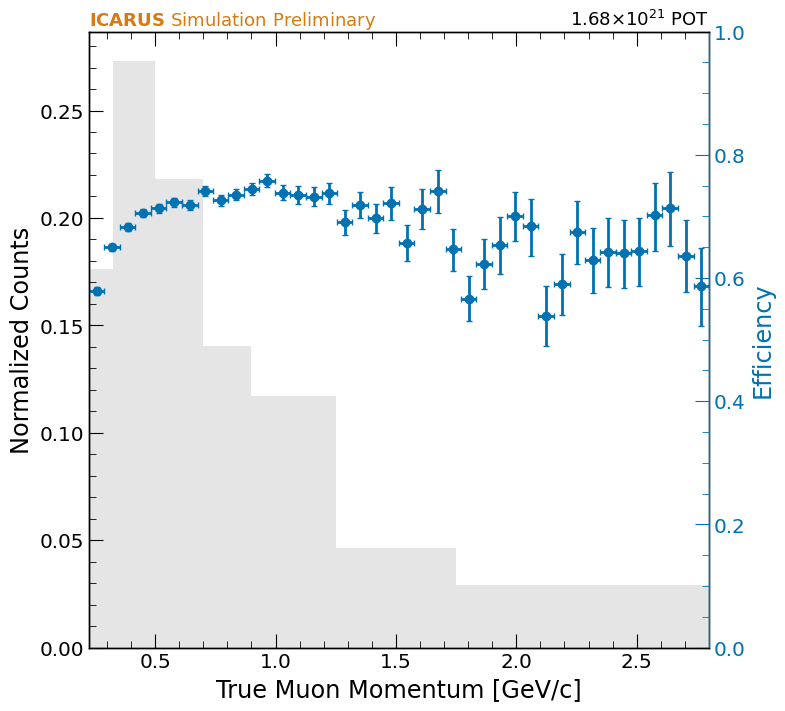

In [8]:
plot_eff_by_var(signal_df, sim_pot, _true_vars[0], cuts, ana_eff_bins_equal=False, nbins_eff=40)